<a href="https://colab.research.google.com/github/maddogmikeb/Jira/blob/master/UltimateSprintReport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install dependencies

from IPython.core.display import clear_output

!pip install -q atlassian-python-api
!pip install -q tqdm
!pip install -q matplotlib

clear_output()

In [2]:
from IPython.core.display import clear_output

sprint_report_url = input("Please enter the 'classic Jira sprint report' url:")

clear_output()

In [3]:
# Configure display

from IPython.core.display import clear_output
from google.colab import data_table
import json

data_table.enable_dataframe_formatter()

def printjson(obj):
  print(json.dumps(obj, indent=2))

clear_output()

In [4]:
# Log in

from IPython.core.display import display, HTML, clear_output
from atlassian import Jira
from google.colab import userdata
from urllib.parse import urlparse

parsed_uri = urlparse(sprint_report_url)
base_url = '{uri.scheme}://{uri.netloc}/'.format(uri=parsed_uri)

jira = Jira(
  url=base_url,
  username=userdata.get('atlassian_username'),
  password=userdata.get('atlassian_apikey'),
  cloud=True
)

me = jira.myself()

display(HTML('<table><tr><td>' + me["displayName"] + '</td><td><img src="' + me["avatarUrls"]["32x32"] + '"/><td></tr></table>'))


Mike Burns


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import io
from PIL import Image

def fig2img(fig):
  # Convert a Matplotlib figure to a PIL Image and return it
  buf = io.BytesIO()
  fig.savefig(buf)
  buf.seek(0)
  img = Image.open(buf)
  return img

class DataPoint:
  def __init__(self, name, count, points, color, edgeColor):
    self.name = name
    self.count = count
    self.points = points
    self.color = color
    self.hatch = 'X'
    self.edgeColor = edgeColor

  def getValues(self):
    return [self.count, self.points]

def cumulateData(dataArray):
  data = np.array(dataArray)
  data_shape = np.shape(data)

  # Take negative and positive data apart and cumulate
  def get_cumulated_array(data, **kwargs):
      cum = data.clip(**kwargs)
      cum = np.cumsum(cum, axis=0)
      d = np.zeros(np.shape(data))
      d[1:] = cum[:-1]
      return d

  cumulated_data = get_cumulated_array(data, min=0)
  cumulated_data_neg = get_cumulated_array(data, max=0)

  # Re-merge negative and positive data.
  row_mask = (data<0)
  cumulated_data[row_mask] = cumulated_data_neg[row_mask]
  data_stack = cumulated_data

  return data, data_shape, data_stack

In [6]:
status_categories = jira.get("/rest/api/2/statuscategory")

In [15]:
response = jira.request(absolute=True, method="GET", path=base_url + "/rest/greenhopper/latest/rapid/charts/sprintreport?rapidViewId=364&sprintId=822")
sprint_report = json.loads(response.content)

In [18]:
ToDoEstimate = 0
ToDoCount = 0
ProgressEstimate = 0
ProgressCount = 0

TODO_KEY_ID =  str([x['id'] for x in status_categories if x['name'] == 'To Do'][0])
INPROGRESS_KEY_ID  = str([x['id'] for x in status_categories if x['name'] == 'In Progress'][0])

for issue in sprint_report["contents"]["issuesNotCompletedInCurrentSprint"]:
  if issue["status"]["statusCategory"]['id'] == TODO_KEY_ID:
    ToDoCount += 1
    ToDoEstimate += issue['estimateStatistic']['statFieldValue']['value']

  if issue["status"]["statusCategory"]['id'] == INPROGRESS_KEY_ID:
    ProgressCount += 1
    ProgressEstimate += issue['estimateStatistic']['statFieldValue']['value'] if "value" in issue['estimateStatistic']['statFieldValue'] else 0

Removed = DataPoint(
    'Removed',
    -1 * len(sprint_report["contents"]["puntedIssues"]),
    -1 * sprint_report["contents"]['puntedIssuesEstimateSum']['value'] if "value" in sprint_report["contents"]["puntedIssuesEstimateSum"] else 0,
    '#d04437',
    '#ccc'
  )

ToDo = DataPoint(
    'ToDo',
    ToDoCount,
    ToDoEstimate,
    '#091E420F',
    '#44546F'
  )

InProgress = DataPoint(
    'InProgress',
    ProgressCount,
    ProgressEstimate,
    '#deebff',
    '#0055CC'
  )

Done = DataPoint(
    'Completed',
    len(sprint_report["contents"]["completedIssues"]),
    sprint_report["contents"]["completedIssuesEstimateSum"]['value'] if "value" in sprint_report["contents"]["completedIssuesEstimateSum"] else 0,
    '#e3fcef',
    '#216E4E'
  )

CompletedOutside = DataPoint(
    'Completed Outside',
    len(sprint_report["contents"]["issuesCompletedInAnotherSprint"]),
    sprint_report["contents"]["issuesCompletedInAnotherSprintEstimateSum"]['value'] if "value" in sprint_report["contents"]["issuesCompletedInAnotherSprintEstimateSum"] else 0,
    '#e3fcef',
    '#216E4E'
  )

TotalCommitted = [2, 2]
TotalCompleted = [Done.count + CompletedOutside.count, Done.points + CompletedOutside.points]

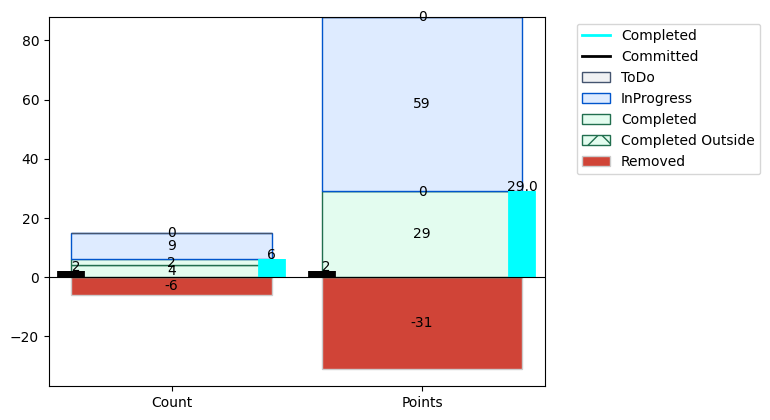

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

col_labels = ['Count', 'Points']

cols = [Removed.color, Done.color, CompletedOutside.color, InProgress.color, ToDo.color]
edgeColors = [Removed.edgeColor, Done.edgeColor, CompletedOutside.edgeColor, InProgress.edgeColor, ToDo.edgeColor]
values = [Removed.getValues(), Done.getValues(), CompletedOutside.getValues(), InProgress.getValues(), ToDo.getValues()]

data, data_shape, data_stack = cumulateData(values)

ax = plt.subplot(111)

for i in np.arange(0, data_shape[0]):
  bars = ax.bar(np.arange(data_shape[1]), data[i], bottom=data_stack[i], color=cols[i], edgecolor=edgeColors[i], )
  for bar in bars:
     height = bar.get_height()
     ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{int(height)}', ha='center', va='center', color='black')

for i in range(len(TotalCompleted)):
  lines = ax.vlines(x=i+0.4, ymin=0, ymax=(TotalCompleted[i]), color='cyan', linestyle='solid', linewidth=20,)
  ax.text(i+0.4, (TotalCompleted[i])+0.2, f'{(TotalCompleted[i])}', color='black', horizontalalignment='center')

for i in range(len(TotalCommitted)):
  ax.vlines(x=i-0.4, ymin=0, ymax=(TotalCommitted[i]), color='black', linestyle='solid', linewidth=20,)
  ax.text(i-0.4, (TotalCommitted[i])+0.2, f'{(str(TotalCommitted[i]).rjust(3))}', color='black', horizontalalignment='center')

ax.set_xticks(np.arange(data_shape[1]))
ax.set_xticklabels(col_labels)

ax.axhline(0, color='black', linewidth=0.8)

legend_elements = [
    Line2D([0], [0], color='cyan', lw=2, label='Completed'),
    Line2D([0], [0], color='black', lw=2, label='Committed'),
    Patch(facecolor=ToDo.color, edgecolor=ToDo.edgeColor, label=ToDo.name),
    Patch(facecolor=InProgress.color, edgecolor=InProgress.edgeColor, label=InProgress.name),
    Patch(facecolor=Done.color, edgecolor=Done.edgeColor, label=Done.name),
    Patch(facecolor=CompletedOutside.color, edgecolor=CompletedOutside.edgeColor, hatch="X", label=CompletedOutside.name),
    Patch(facecolor=Removed.color, edgecolor=Removed.edgeColor, label=Removed.name)
  ]

ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

#plt.show()

img = fig2img(plt.gcf())
img.show()